#### Develop Sentiment Analysis

In [106]:
!pip install pyLDAvis

  Using cached pyLDAvis-3.4.1-py3-none-any.whl (2.6 MB)
  Using cached pandas-2.2.2-cp310-cp310-win_amd64.whl (11.6 MB)
  Using cached FuzzyTM-2.0.9-py3-none-any.whl (31 kB)
  Using cached pyFUME-0.3.4-py3-none-any.whl (60 kB)
  Using cached simpful-2.12.0-py3-none-any.whl (24 kB)
  Using cached scipy-1.10.1-cp310-cp310-win_amd64.whl (42.5 MB)
  Using cached numpy-1.24.4-cp310-cp310-win_amd64.whl (14.8 MB)
  Using cached pyFUME-0.3.1-py3-none-any.whl (59 kB)
  Using cached fst_pso-1.8.1-py3-none-any.whl
  Using cached miniful-0.0.6-py3-none-any.whl
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Orie\\anaconda3\\Lib\\site-packages\\~andas\\_libs\\algos.cp310-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [114]:
#Import libraries
import pandas as pd
import numpy as np
import json
import spacy
import matplotlib.pyplot as plt
import datetime
import steamreviews
from textblob import TextBlob

import bbcode
import string
import re
from spacy_langdetect import LanguageDetector

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel, LdaModel, LdaMulticore
import nltk
from nltk.stem import WordNetLemmatizer

import wordcloud

import gensim

%matplotlib inline

### API Setup and Data Scraping

In [2]:
#Create environment
import os

os.environ['STEAM_API_KEY'] = "54FC46746251551FF928ECC853894D9F"

# Verify that the environment variable is set
print(os.environ['STEAM_API_KEY'])

54FC46746251551FF928ECC853894D9F


In [3]:
#Searching for user
from steam_web_api import Steam

KEY = os.environ.get("STEAM_API_KEY")
steam = Steam(KEY)


# Check to see if API is working by retrieving my profile
myprofile = steam.users.get_user_details("76561198034344673")
myprofile

{'player': {'steamid': '76561198034344673',
  'communityvisibilitystate': 3,
  'profilestate': 1,
  'personaname': 'SnotOtter',
  'profileurl': 'https://steamcommunity.com/profiles/76561198034344673/',
  'avatar': 'https://avatars.steamstatic.com/e8c7139c813869bf238fa2edf026dae7e20cd529.jpg',
  'avatarmedium': 'https://avatars.steamstatic.com/e8c7139c813869bf238fa2edf026dae7e20cd529_medium.jpg',
  'avatarfull': 'https://avatars.steamstatic.com/e8c7139c813869bf238fa2edf026dae7e20cd529_full.jpg',
  'avatarhash': 'e8c7139c813869bf238fa2edf026dae7e20cd529',
  'lastlogoff': 1716322698,
  'personastate': 1,
  'primaryclanid': '103582791429521408',
  'timecreated': 1291063626,
  'personastateflags': 0,
  'loccountrycode': 'US'}}

In [4]:
#Define params for steamreviews
#steamreviews by woctezuma @ https://github.com/woctezuma/download-steam-reviews/tree/master/steamreviews

request_params = dict()
request_params['language'] = 'english'  #input language of choice
request_params['day_range'] = '365'     #get reviews up to 1 year back from current date

app_id = 1145350     #Hades 2

review_dict, query_count = steamreviews.download_reviews_for_app_id(app_id, chosen_request_params=request_params)  #writes to a /data/ folder in same dir as this ipynb

[appID = 1145350] expected #reviews = 20934


In [5]:
#read in data as json file; replace this JSON with any JSON scraped for a steam game using Steam game's JSON
with open('C:\\Users\\Orie\\Desktop\\InstituteofData\\Capstone\\data\\review_1145350.json') as jsonfile:
    jayson = json.load(jsonfile)

In [115]:
#
review_data = [v for v in jayson['reviews'].values()]
author_key_list = list(review_data[0]['author'].keys())

### EDA

In [7]:
len(review_data)

20880

In [8]:
review_data

[{'recommendationid': '165751955',
  'author': {'steamid': '76561199229049073',
   'num_games_owned': 0,
   'num_reviews': 3,
   'playtime_forever': 1576,
   'playtime_last_two_weeks': 1576,
   'playtime_at_review': 1576,
   'last_played': 1716220295},
  'language': 'english',
  'review': "Remember Hades 1? Yeah the sequel's even better. No im not making it up theres so much more content, the same level of variety if not more, even more hot gods and cute characters. If youre worried about the price, trust me its -very- worth it.",
  'timestamp_created': 1716229487,
  'timestamp_updated': 1716229487,
  'voted_up': True,
  'votes_up': 0,
  'votes_funny': 0,
  'weighted_vote_score': 0,
  'comment_count': 0,
  'steam_purchase': True,
  'received_for_free': False,
  'written_during_early_access': True,
  'hidden_in_steam_china': True,
  'steam_china_location': ''},
 {'recommendationid': '165751697',
  'author': {'steamid': '76561197995862649',
   'num_games_owned': 0,
   'num_reviews': 7,
 

In [9]:
#for definition of each field in the JSON files, visit (here)[https://partner.steamgames.com/doc/store/getreviews]
#tested for loop at first, but comprehensions much faster. Completed the operation within 1 minute vs for loop incomplete after 10 min

steam_dict = {'recommendationid':[review_data[i]['recommendationid'] for i in range(len(review_data))],
              
              'author_steamid':[review_data[i]['author']['steamid'] for i in range(len(review_data))],
              
              'author_num_games_owned':[review_data[i]['author']['num_games_owned'] for i in range(len(review_data))],
              
              'author_num_reviews':[review_data[i]['author']['num_reviews'] for i in range(len(review_data))],
              
              'author_playtime_forever':[review_data[i]['author']['playtime_forever'] for i in range(len(review_data))], 
              #data recorded in minutes - independently verified: https://steamcommunity.com/id/mydogsnameissnowballball/recommended/730/ - 43586 divided by 724.6h on record = 60 min
              
              'author_playtime_last_two_weeks':[review_data[i]['author']['playtime_last_two_weeks'] for i in range(len(review_data))],
              
              'author_last_played':[review_data[i]['author']['last_played'] for i in range(len(review_data))],
              
              'review':[review_data[i]['review'] for i in range(len(review_data))],
              
              'timestamp_created':[review_data[i]['timestamp_created'] for i in range(len(review_data))],
              
              'timestamp_updated':[review_data[i]['timestamp_updated'] for i in range(len(review_data))],
              
              'voted_up':[review_data[i]['voted_up'] for i in range(len(review_data))],
              
              'weighted_vote_score':[review_data[i]['weighted_vote_score'] for i in range(len(review_data))],
              
              'steam_purchase':[review_data[i]['steam_purchase'] for i in range(len(review_data))],
              
              'received_for_free':[review_data[i]['received_for_free'] for i in range(len(review_data))],
              
              'written_during_early_access':[review_data[i]['written_during_early_access'] for i in range(len(review_data))]}

In [10]:
df_raw = pd.DataFrame(steam_dict)
df_raw.head()

,recommendationid,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_last_played,review,timestamp_created,timestamp_updated,voted_up,weighted_vote_score,steam_purchase,received_for_free,written_during_early_access
0,165751955,76561199229049073,0,3,1576,1576,1716220295,Remember Hades 1? Yeah the sequel's even bette...,1716229487,1716229487,True,0,True,False,True
1,165751697,76561197995862649,0,7,1556,1556,1716134695,Game is truly great and I couldn't RECOMMEND i...,1716229128,1716229128,False,0,True,False,True
2,165751528,76561198925145075,0,7,355,355,1716230727,We need more companies making this style this way,1716228929,1716228929,True,0,True,False,True
3,165751462,76561198036505343,0,10,2462,2411,1716228827,Game's good,1716228838,1716228838,True,0,True,False,True
4,165751456,76561198067594318,0,16,605,605,1716224347,I am fully prepared to face the backlash from ...,1716228834,1716229468,False,0,True,False,True


In [11]:
#check for duplicate reviews

abs(len(df_raw['recommendationid'].unique()) - len(df_raw))

0

In [12]:
df_raw.dtypes

recommendationid                  object
author_steamid                    object
author_num_games_owned             int64
author_num_reviews                 int64
author_playtime_forever            int64
author_playtime_last_two_weeks     int64
author_last_played                 int64
review                            object
timestamp_created                  int64
timestamp_updated                  int64
voted_up                            bool
weighted_vote_score               object
steam_purchase                      bool
received_for_free                   bool
written_during_early_access         bool
dtype: object

In [13]:
#Check to see positive ratings:
#check class balance of player-provided sentiment label
df_raw['voted_up'].value_counts(normalize=True)

True     0.970546
False    0.029454
Name: voted_up, dtype: float64

In [14]:
#Convert author playtime data to hours (recorded in minutes in JSON)

df_raw['author_playtime_forever']=df_raw['author_playtime_forever']/60

df_raw['author_playtime_last_two_weeks']=df_raw['author_playtime_last_two_weeks']/60

In [15]:
df_raw['steam_purchase'].value_counts(normalize=True)

True     0.962452
False    0.037548
Name: steam_purchase, dtype: float64

In [16]:
df_raw['review_length'] = df_raw['review'].map(lambda x: len(x.split()))

In [17]:
df_raw.describe()

,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_last_played,timestamp_created,timestamp_updated,review_length
count,20880.000000,20880.000000,20880.000000,20880.000000,2.088000e+04,2.088000e+04,2.088000e+04,20880.000000
mean,121.869684,15.343630,27.724830,27.506680,1.715900e+09,1.715392e+09,1.715407e+09,34.351772
std,326.814683,28.291536,21.874592,21.807508,3.309780e+05,3.513903e+05,3.541469e+05,88.088488
min,0.000000,1.000000,0.083333,0.000000,1.714574e+09,1.715015e+09,1.715015e+09,0.000000
25%,0.000000,3.000000,13.416667,13.262500,1.715679e+09,1.715103e+09,1.715111e+09,4.000000
50%,0.000000,7.000000,23.733333,23.516667,1.716008e+09,1.715279e+09,1.715295e+09,10.000000
75%,138.000000,17.000000,36.350000,36.066667,1.716169e+09,1.715606e+09,1.715630e+09,29.000000
max,18210.000000,1125.000000,325.683333,323.400000,1.716402e+09,1.716378e+09,1.716402e+09,1531.000000


In [18]:
#Exclude reviews from those who have played less than 2 hours
df_raw_num_high_play = df_raw[(df_raw['author_playtime_forever']>2)]
len(df_raw_num_high_play)

20294

In [19]:
#summarise the remaining data
df_raw_num_high_play.describe()

,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_last_played,timestamp_created,timestamp_updated,review_length
count,20294.000000,20294.000000,20294.000000,20294.000000,2.029400e+04,2.029400e+04,2.029400e+04,20294.000000
mean,116.759683,14.818666,28.495297,28.273681,1.715917e+09,1.715396e+09,1.715412e+09,34.346851
std,303.905302,26.999872,21.706077,21.640882,3.151137e+05,3.514093e+05,3.540559e+05,88.709053
min,0.000000,1.000000,2.016667,0.000000,1.714574e+09,1.715015e+09,1.715015e+09,0.000000
25%,0.000000,3.000000,14.416667,14.266667,1.715712e+09,1.715106e+09,1.715114e+09,4.000000
50%,0.000000,7.000000,24.350000,24.133333,1.716019e+09,1.715285e+09,1.715299e+09,10.000000
75%,135.000000,16.000000,36.845833,36.583333,1.716171e+09,1.715613e+09,1.715635e+09,28.000000
max,18210.000000,1125.000000,325.683333,323.400000,1.716402e+09,1.716378e+09,1.716402e+09,1531.000000


Text(0.5, 0, 'Hours Played')

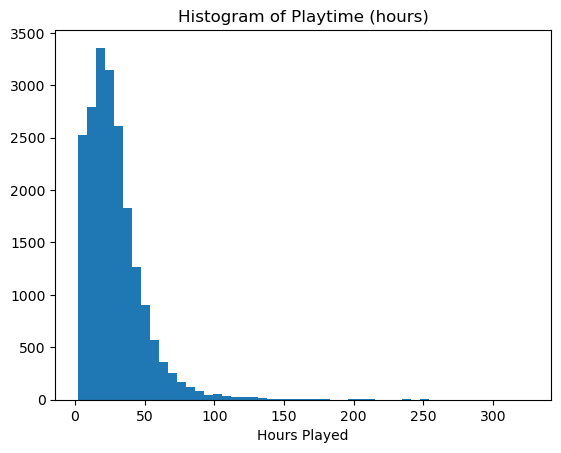

In [117]:
#Histogram of play time
plt.hist(df_raw_num_high_play['author_playtime_forever'],bins=50)
plt.title('Histogram of Playtime (hours)')
plt.xlabel('Hours Played')

In [21]:
df_raw_num_high_play

,recommendationid,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_last_played,review,timestamp_created,timestamp_updated,voted_up,weighted_vote_score,steam_purchase,received_for_free,written_during_early_access,review_length
0,165751955,76561199229049073,0,3,26.266667,26.266667,1716220295,Remember Hades 1? Yeah the sequel's even bette...,1716229487,1716229487,True,0,True,False,True,46
1,165751697,76561197995862649,0,7,25.933333,25.933333,1716134695,Game is truly great and I couldn't RECOMMEND i...,1716229128,1716229128,False,0,True,False,True,102
2,165751528,76561198925145075,0,7,5.916667,5.916667,1716230727,We need more companies making this style this way,1716228929,1716228929,True,0,True,False,True,9
3,165751462,76561198036505343,0,10,41.033333,40.183333,1716228827,Game's good,1716228838,1716228838,True,0,True,False,True,2
4,165751456,76561198067594318,0,16,10.083333,10.083333,1716224347,I am fully prepared to face the backlash from ...,1716228834,1716229468,False,0,True,False,True,1024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20875,165752596,76561198045604743,281,9,28.233333,28.233333,1716318201,"Hades 2 is a masterclass in game design, build...",1716230226,1716230226,True,0,True,False,True,97
20876,165752252,76561199344205463,0,7,105.683333,86.150000,1716401254,is good,1716229843,1716229843,True,0.538461565971374512,True,False,True,2
20877,165752098,76561199481413207,0,1,58.966667,48.600000,1716145666,After a couple 100 hours in Hades (not even 10...,1716229662,1716229662,True,0,True,False,True,272
20878,165752042,76561198041962567,0,29,28.666667,28.666667,1716399819,game good,1716229585,1716229585,True,0,True,False,True,2


In [22]:
#First review
df_raw_num_high_play.iloc[0,7]

"Remember Hades 1? Yeah the sequel's even better. No im not making it up theres so much more content, the same level of variety if not more, even more hot gods and cute characters. If youre worried about the price, trust me its -very- worth it."

In [23]:
#Review words
df_raw_num_high_play['review'].describe()

count                20294
unique               17994
top       Death to Chronos
freq                   182
Name: review, dtype: object

In [24]:
review_lengths = [len(x.split()) for x in df_raw_num_high_play['review']]
print(len(review_lengths)) #no of reviews
print(sum(review_lengths)/len(review_lengths)) #mean character length of a review
df_raw_num_high_play['review_length']=df_raw_num_high_play['review'].map(lambda x: len(x.split()))

20294
34.34685128609441


C:\Users\Orie\AppData\Local\Temp\ipykernel_11644\565148006.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw_num_high_play['review_length']=df_raw_num_high_play['review'].map(lambda x: len(x.split()))


Text(0.5, 0, '# of Words')

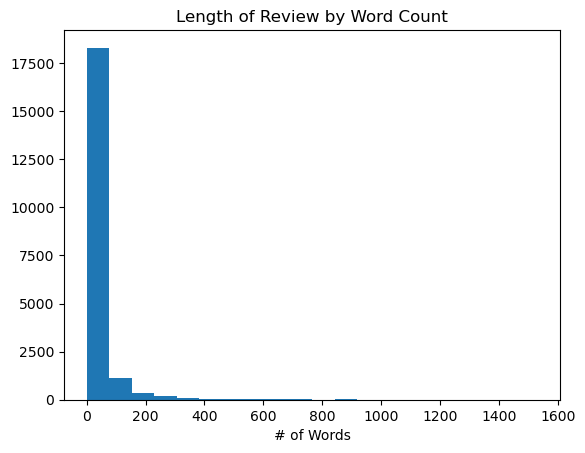

In [119]:

#plot distribution of review lengths -- longer reviews more usable

plt.hist(df_raw_num_high_play['review_length'],bins=20)
plt.title('Length of Review by Word Count')
plt.xlabel('# of Words')

In [26]:
#descriptive summary for filtered reviews

high_play_data = df_raw_num_high_play.describe()[['author_num_games_owned','author_playtime_forever','author_playtime_last_two_weeks','review_length']]

for col in high_play_data:
    high_play_data[col] = high_play_data[col].map(lambda x: round(x,2))

high_play_data

,author_num_games_owned,author_playtime_forever,author_playtime_last_two_weeks,review_length
count,20294.00,20294.00,20294.00,20294.00
mean,116.76,28.50,28.27,34.35
std,303.91,21.71,21.64,88.71
min,0.00,2.02,0.00,0.00
25%,0.00,14.42,14.27,4.00
50%,0.00,24.35,24.13,10.00
75%,135.00,36.85,36.58,28.00
max,18210.00,325.68,323.40,1531.00


(array([1.9916e+04, 3.0700e+02, 4.4000e+01, 1.3000e+01, 7.0000e+00,
        3.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([    0. ,   910.5,  1821. ,  2731.5,  3642. ,  4552.5,  5463. ,
         6373.5,  7284. ,  8194.5,  9105. , 10015.5, 10926. , 11836.5,
        12747. , 13657.5, 14568. , 15478.5, 16389. , 17299.5, 18210. ]),
 <BarContainer object of 20 artists>)

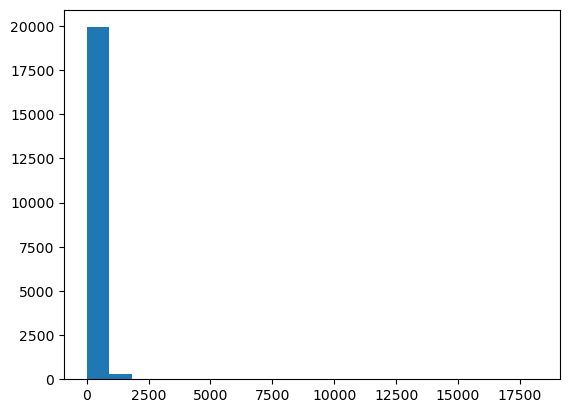

In [27]:
#Investigate low number of games owned:
plt.hist(df_raw_num_high_play['author_num_games_owned'],bins=20)

In [28]:
#cut off review lengths at the 25th percentile. 
#Short reviews contain too little info, but we can't discard too much data either.

np.percentile(df_raw_num_high_play['review_length'],25)

4.0

In [29]:
df_ready = df_raw_num_high_play[df_raw_num_high_play['review_length']>np.percentile(df_raw_num_high_play['review_length'],25)].reset_index(drop=True) #Remove very short reviews that are likely to be junk

In [30]:
print('Min length:',min(df_ready['review_length']),'words') #shortest review length. 
df_ready.head()

Min length: 5 words


,recommendationid,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_last_played,review,timestamp_created,timestamp_updated,voted_up,weighted_vote_score,steam_purchase,received_for_free,written_during_early_access,review_length
0,165751955,76561199229049073,0,3,26.266667,26.266667,1716220295,Remember Hades 1? Yeah the sequel's even bette...,1716229487,1716229487,True,0,True,False,True,46
1,165751697,76561197995862649,0,7,25.933333,25.933333,1716134695,Game is truly great and I couldn't RECOMMEND i...,1716229128,1716229128,False,0,True,False,True,102
2,165751528,76561198925145075,0,7,5.916667,5.916667,1716230727,We need more companies making this style this way,1716228929,1716228929,True,0,True,False,True,9
3,165751456,76561198067594318,0,16,10.083333,10.083333,1716224347,I am fully prepared to face the backlash from ...,1716228834,1716229468,False,0,True,False,True,1024
4,165751430,76561198080721816,0,1,26.450000,26.450000,1716186371,Even in Early Access there's more content to e...,1716228806,1716228806,True,0,True,False,True,54


In [31]:
#Check how much data remains
len(df_ready)

14291

In [32]:
#descriptive summary for filtered reviews

ready_data = df_ready.describe()[['author_num_games_owned','author_playtime_forever','author_playtime_last_two_weeks','review_length']]

for col in ready_data:
    ready_data[col] = ready_data[col].map(lambda x: round(x,2))

ready_data

,author_num_games_owned,author_playtime_forever,author_playtime_last_two_weeks,review_length
count,14291.00,14291.00,14291.00,14291.00
mean,120.23,28.97,28.74,47.79
std,315.83,21.97,21.90,102.78
min,0.00,2.02,0.35,5.00
25%,0.00,14.63,14.46,9.00
50%,0.00,24.77,24.52,18.00
75%,138.00,37.65,37.32,43.00
max,18210.00,299.57,298.48,1531.00


In [33]:
#preview 1 review
df_ready.iloc[0,7] #Most reviews are between 4 and 200 words long.

"Remember Hades 1? Yeah the sequel's even better. No im not making it up theres so much more content, the same level of variety if not more, even more hot gods and cute characters. If youre worried about the price, trust me its -very- worth it."

In [34]:
#summarise the new df
df_ready['review'].describe()

count                    14291
unique                   14217
top       You can pet the frog
freq                        19
Name: review, dtype: object

In [35]:
#What are the 10 most duplicated reviews?
#Steam reviews tend to be spammy 
df_ready['review'].value_counts()[:10] 

You can pet the frog                                    19
you can pet the frog                                     6
You can pet the frog.                                    5
"In the name of hades, Olympus i accept this sequel"     5
game of the year 2024                                    3
Great game for killing time                              3
Even better than the first                               3
you can pet the cat                                      3
You can pet the cat.                                     3
In the name of Hades! Olympus, I accept this sequel!     3
Name: review, dtype: int64

In [120]:
#drop duplicate entries in reviews, because they are considered spam
df_cleaning = df_ready.drop_duplicates(subset=['author_steamid','review'])

In [121]:
len(df_cleaning)

14291

### Text Cleaning

In [37]:
parser=bbcode.Parser()

In [38]:
#expand contractions e.g. can't, won't to cannot, will not
#easier to remove stopwords

#Source: https://gist.github.com/nealrs/96342d8231b75cf4bb82 (Modified for my own use)


with open('C:/Users/Orie/Desktop/InstituteofData/Capstone/contra_dict.txt') as contra_dict:  #open pre-defined dictionary of english contractions, saved separately to avoid clutter
    cList = json.load(contra_dict)

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text.lower())

In [39]:
#define stopwords (common words with no meaning by themselves)

num_dict = {'0':'zero',
            '1':'one',
            '2':'two',
            '3':'three',
            #'i':'one',      skipped. Using Roman numeral 'i' will conflict with the pronoun "I", which is not a number
            'ii':'two',
            'iii':'three'   
            }

def num2word(d):
    
    if (len(d) == 1 and d in '0123')  or (d in ['ii','iii']):
        word = num_dict[d]
    
    elif (len(str(d))==1 and str(d) in '0123'):
        word = num_dict(str(d))
    
    else:
        word = d
    
    return word

en_stopwords = list(set(STOPWORDS))
en_stopwords.extend(['good','better','great','lot','game','like','I','i'])
en_stopwords = [w for w in en_stopwords if w not in ['one','two','three']]    #retain these for making n-grams

def remove_stopwords(doc):
    words = [num2word(w) for w in doc if w != '' and w not in en_stopwords]
    return words

In [40]:
def parse_clean(text):
    parsed_text = parser.strip(text) #remove BBcode notations from text
    
    text = expandContractions(parsed_text) #expand contractions; return all text in lower case
    
    text = re.split(r'\W+',text) #separate words from punctuation (e.g. remove 's from "Cao Cao's")
    
    text = [num2word(w) for w in text] #convert single digits to words before word len check, or they will be lost
    
    #All word lengths should be >1 character and <= length of the longest word in the English language. It's common for people spam incoherent letters on the Internet.
    text = [word for word in text if word not in en_stopwords and len(word)>1 and len(word) <= len('pneumonoultramicroscopicsilicovolcanoconiosis')] 
    
    #clean_text = [num2word(w) for w in text] #just in case any lone numbers appeared after cleaning
    
    return text

In [41]:
txt = df_cleaning['review'][np.random.randint(0,len(df_cleaning))]
print(txt,'\n')
print(parse_clean(txt))

Game's been out 27 hours and I've put 20 into it already, says it all 

['27', 'hours', 've', '20', 'says']


In [42]:
df_cleaning['clean_reviews'] = df_cleaning['review'].map(lambda x: parse_clean(x))

In [43]:
df_cleaning.head(2)

,recommendationid,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_last_played,review,timestamp_created,timestamp_updated,voted_up,weighted_vote_score,steam_purchase,received_for_free,written_during_early_access,review_length,clean_reviews
0,165751955,76561199229049073,0,3,26.266667,26.266667,1716220295,Remember Hades 1? Yeah the sequel's even bette...,1716229487,1716229487,True,0,True,False,True,46,"[remember, hades, one, yeah, sequel, im, makin..."
1,165751697,76561197995862649,0,7,25.933333,25.933333,1716134695,Game is truly great and I couldn't RECOMMEND i...,1716229128,1716229128,False,0,True,False,True,102,"[truly, recommend, fr, correct, negatives, pos..."


In [44]:
#Save!
df_cleaning.to_csv('C:/Users/Orie/Desktop/InstituteofData/Capstone/df_langs_cleaned.csv')

In [45]:
final_df = pd.read_csv('C:/Users/Orie/Desktop/InstituteofData/Capstone/df_langs_cleaned.csv',index_col=0)

In [46]:
final_df = final_df[['timestamp_created','review','clean_reviews']]
final_df.head()

,timestamp_created,review,clean_reviews
0,1716229487,Remember Hades 1? Yeah the sequel's even bette...,"['remember', 'hades', 'one', 'yeah', 'sequel',..."
1,1716229128,Game is truly great and I couldn't RECOMMEND i...,"['truly', 'recommend', 'fr', 'correct', 'negat..."
2,1716228929,We need more companies making this style this way,"['need', 'companies', 'making', 'style', 'way']"
3,1716228834,I am fully prepared to face the backlash from ...,"['fully', 'prepared', 'face', 'backlash', 'rev..."
4,1716228806,Even in Early Access there's more content to e...,"['early', 'access', 'content', 'explore', 'had..."


In [47]:
final_df['clean_reviews'] = final_df['clean_reviews'].map(lambda x: ''.join(c for c in x if c not in string.punctuation).split()) 
#Reading in the DF from a CSV turned the list of words in each cell into string, so we have to remove the punctuation and split them again

In [48]:

final_df.head()

,timestamp_created,review,clean_reviews
0,1716229487,Remember Hades 1? Yeah the sequel's even bette...,"[remember, hades, one, yeah, sequel, im, makin..."
1,1716229128,Game is truly great and I couldn't RECOMMEND i...,"[truly, recommend, fr, correct, negatives, pos..."
2,1716228929,We need more companies making this style this way,"[need, companies, making, style, way]"
3,1716228834,I am fully prepared to face the backlash from ...,"[fully, prepared, face, backlash, review, apol..."
4,1716228806,Even in Early Access there's more content to e...,"[early, access, content, explore, hades, one, ..."


In [49]:
#Time to explore the corpus word frequency.
#Get all words in the corpus

word_lst = []
for i in final_df['clean_reviews']:
    word_lst.extend(i)
    
cleaned_words = word_lst

print(len(word_lst))

281641


In [50]:
#100 most common words in the corpus
wordfreq = nltk.FreqDist(word_lst)
# Print the most common words.
print(wordfreq.most_common(100))

[('hades', 8834), ('one', 5959), ('early', 3655), ('two', 3420), ('access', 3348), ('new', 2697), ('10', 2162), ('time', 2068), ('feels', 1982), ('feel', 1950), ('love', 1727), ('fun', 1727), ('play', 1683), ('far', 1640), ('sequel', 1562), ('story', 1517), ('games', 1429), ('gameplay', 1364), ('supergiant', 1330), ('amazing', 1318), ('weapons', 1277), ('content', 1249), ('boons', 1243), ('way', 1218), ('hours', 1203), ('original', 1193), ('wait', 1188), ('characters', 1143), ('different', 1090), ('played', 1031), ('run', 1030), ('combat', 1007), ('art', 931), ('ve', 904), ('boss', 896), ('things', 871), ('chronos', 868), ('think', 859), ('mechanics', 853), ('playing', 833), ('release', 824), ('best', 784), ('music', 770), ('bit', 738), ('need', 698), ('want', 691), ('character', 689), ('buy', 669), ('death', 659), ('yes', 655), ('enemies', 650), ('three', 644), ('going', 637), ('recommend', 635), ('worth', 618), ('know', 609), ('right', 602), ('frog', 586), ('dash', 580), ('got', 568)

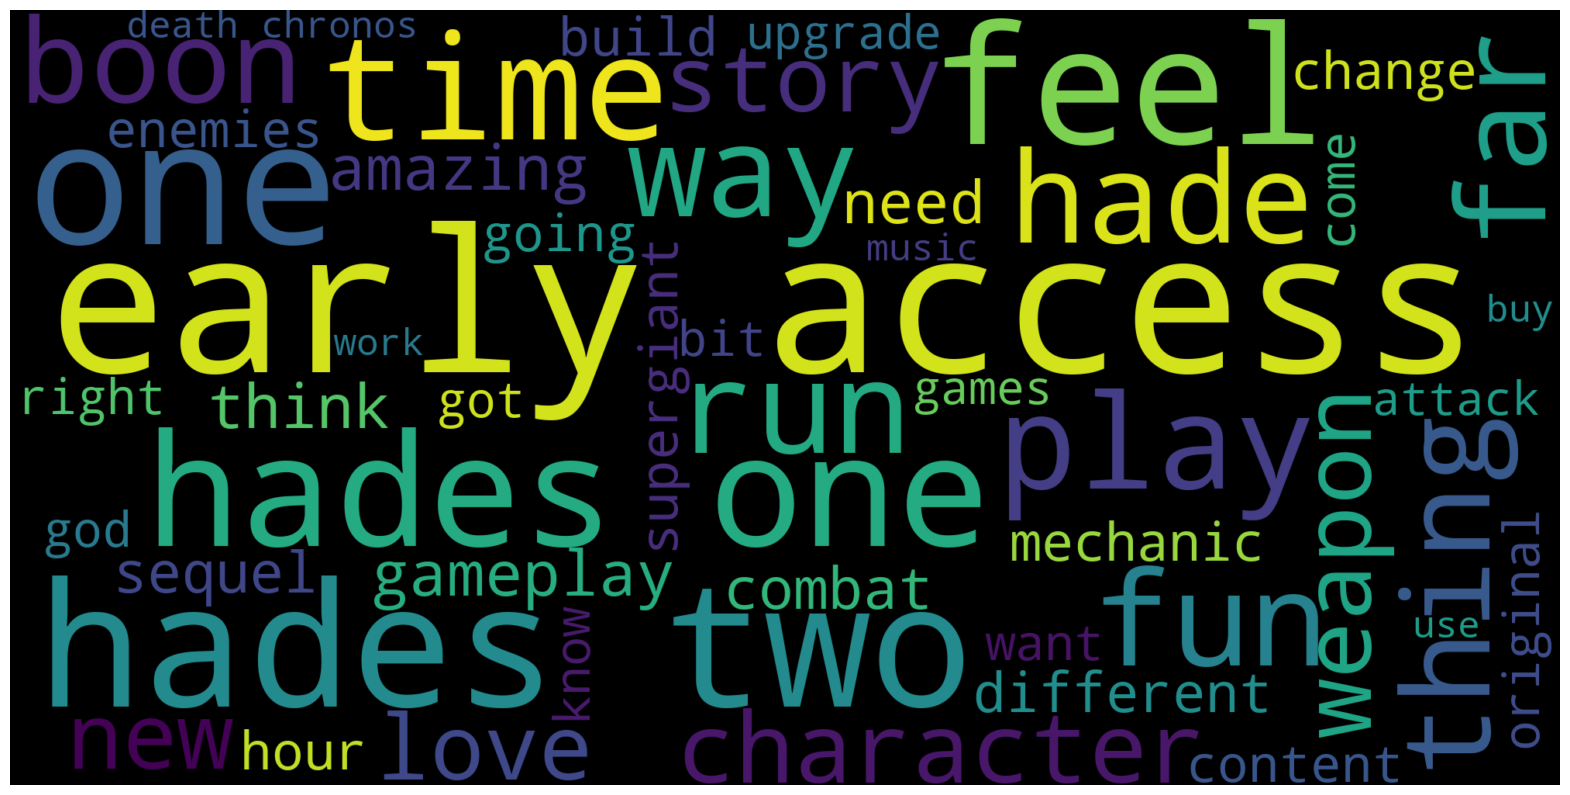

In [51]:
#turn the word list into a str for wordcloud generation
text = ' '.join(w for w in word_lst)

# Create and generate a word cloud image:
wcd = wordcloud.WordCloud(width = 2000, height=1000, max_words = 50).generate(text)

# Display the generated image:
plt.figure(figsize=(20,15))
plt.imshow(wcd, interpolation='bilinear')
plt.axis("off")
plt.show()

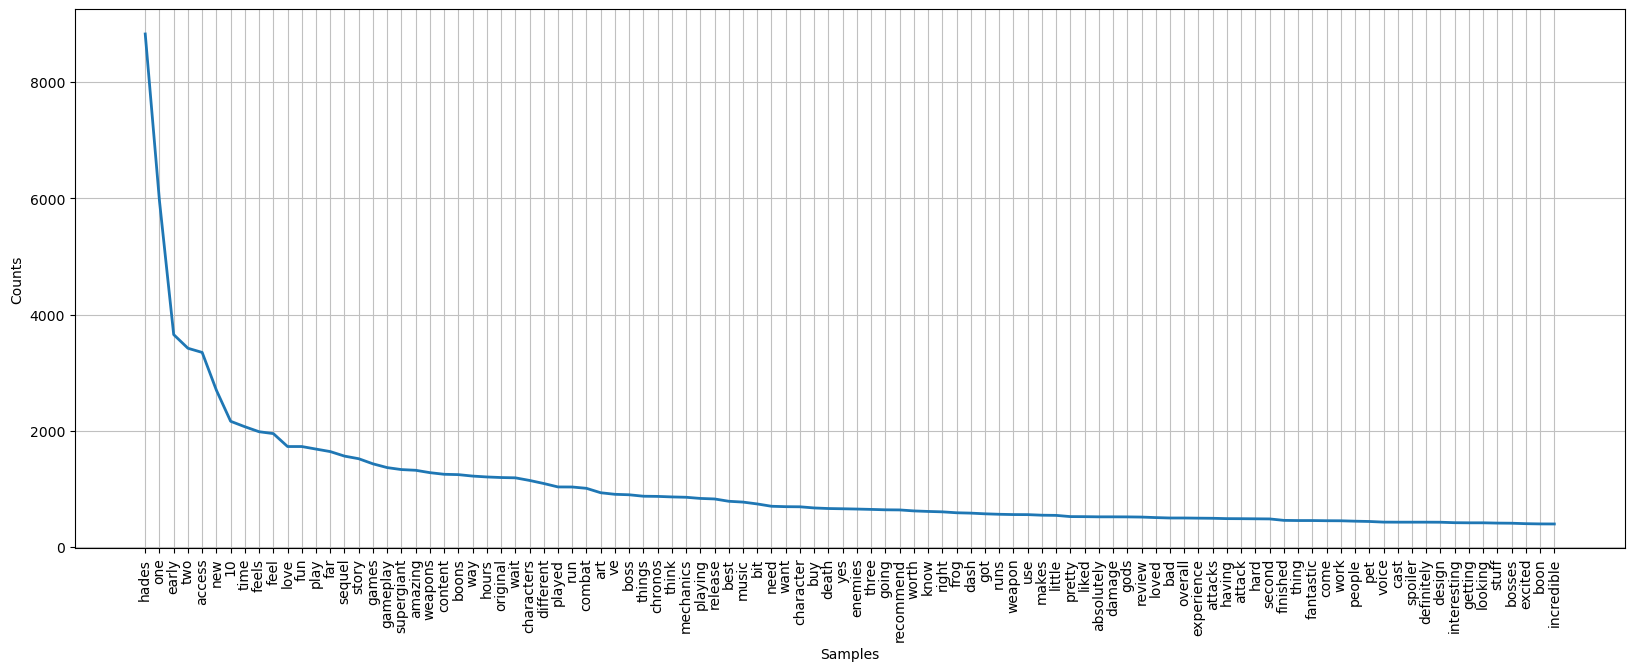

<Axes: xlabel='Samples', ylabel='Counts'>

In [52]:
plt.figure(figsize=(20,7))
wordfreq.plot(100,cumulative=False)

###### First word cloud wasn't super coherent. Let's repeat with phrases.

In [53]:

# Build the bigram and trigram models
bigram = gensim.models.Phrases(list(final_df['clean_reviews']), min_count=5, threshold=10) # feed a list of lists of words e.g. [['word1','word2'],['word3','word4'] to train generator model]
trigram = gensim.models.Phrases(bigram[list(final_df['clean_reviews'])], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [54]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [55]:
def lemma(bow):
    
    #Use SpaCy lemmatiser to lemmatise words.
    lemma_doc = nlp(" ".join(bow)) 

    lemma_text = [token.text if '_' in token.text else token.lemma_ for token in lemma_doc if token.lemma_ != '-PRON-']    #ignore n-grams and pronouns
    
    return lemma_text

In [56]:
def stop_lemma(text):
    text = remove_stopwords(text)
    text = lemma(text)
    return text

#remove newly-added stopwords from clean reviews only after getting bigrams and trigrams just in case those stopwords happen to be part of any n-grams.
#After that, lemmatise.
#Any remaining numbers can be removed at this point, as they are unlikely to be part of any helpful terms.

In [57]:
#testing bigram function
t = [['three', 'kingdoms', 'period'],['romance', 'three', 'kingdoms'],['three', 'kingdoms', 'strategy'],['romance', 'three', 'kingdoms'],
     ['romance','three', 'kingdoms'],['three', 'kingdoms', 'strategy'],['total_war','three', 'kingdoms'],['3', 'kingdoms', 'period'],['three','kingdoms']]

print(make_bigrams(t))

[['three', 'kingdoms', 'period'], ['romance', 'three', 'kingdoms'], ['three', 'kingdoms', 'strategy'], ['romance', 'three', 'kingdoms'], ['romance', 'three', 'kingdoms'], ['three', 'kingdoms', 'strategy'], ['total_war', 'three', 'kingdoms'], ['3', 'kingdoms', 'period'], ['three', 'kingdoms']]


In [58]:
print(make_trigrams(t))

[['three', 'kingdoms', 'period'], ['romance', 'three', 'kingdoms'], ['three', 'kingdoms', 'strategy'], ['romance', 'three', 'kingdoms'], ['romance', 'three', 'kingdoms'], ['three', 'kingdoms', 'strategy'], ['total_war', 'three', 'kingdoms'], ['3', 'kingdoms', 'period'], ['three', 'kingdoms']]


In [59]:
#turning numbers into words was a good idea.
#3grams seem more coherent in general.
#consider adding more stopwords to be cleaned out of the corpus

en_stopwords.extend(['one','two','three']) #removing numbers after making n-grams should reduce noise. 

In [60]:
final_df.head()

,timestamp_created,review,clean_reviews
0,1716229487,Remember Hades 1? Yeah the sequel's even bette...,"[remember, hades, one, yeah, sequel, im, makin..."
1,1716229128,Game is truly great and I couldn't RECOMMEND i...,"[truly, recommend, fr, correct, negatives, pos..."
2,1716228929,We need more companies making this style this way,"[need, companies, making, style, way]"
3,1716228834,I am fully prepared to face the backlash from ...,"[fully, prepared, face, backlash, review, apol..."
4,1716228806,Even in Early Access there's more content to e...,"[early, access, content, explore, hades, one, ..."


In [61]:
final_df['2gram_reviews'] = make_bigrams(final_df['clean_reviews'])

In [62]:
# Load the SpaCy language model
nlp = spacy.load("en_core_web_sm")

In [63]:
final_df['3gram_reviews'] = make_trigrams(final_df['clean_reviews'])

In [64]:
final_df['2gram_reviews'] = final_df['2gram_reviews'].map(lambda x: stop_lemma(x))
final_df['3gram_reviews'] = final_df['3gram_reviews'].map(lambda x: stop_lemma(x))

In [65]:
final_df.head()

,timestamp_created,review,clean_reviews,2gram_reviews,3gram_reviews
0,1716229487,Remember Hades 1? Yeah the sequel's even bette...,"[remember, hades, one, yeah, sequel, im, makin...","[remember, hade, yeah, sequel, I, m, make, the...","[remember, hades_one, yeah, sequel, I, m, make..."
1,1716229128,Game is truly great and I couldn't RECOMMEND i...,"[truly, recommend, fr, correct, negatives, pos...","[truly, recommend, fr, correct, negative, post...","[truly, recommend, fr, correct, negative, post..."
2,1716228929,We need more companies making this style this way,"[need, companies, making, style, way]","[need, company, make, style, way]","[need, company, make, style, way]"
3,1716228834,I am fully prepared to face the backlash from ...,"[fully, prepared, face, backlash, review, apol...","[fully, prepared, face, backlash, review, apol...","[fully, prepared, face, backlash, review, apol..."
4,1716228806,Even in Early Access there's more content to e...,"[early, access, content, explore, hades, one, ...","[early_access, content, explore, hade, worth_p...","[early_access_content, explore, hades_one, wor..."


In [66]:
#check if this cell still has pronoun tag from lemmatising "im" into '-PRON-' and "be", separating the pronoun and verb
final_df['3gram_reviews'][18]

['true',
 'masterpiece',
 'recommend',
 'absolutely',
 'anybody',
 'hour',
 'fact',
 'that',
 's',
 'early_access',
 'go',
 'completely',
 'unnoticed',
 'be',
 'not',
 'little',
 'thing',
 'unfinished',
 'sprite',
 'icon',
 'truly',
 'embrace',
 'complete',
 'predecessor',
 'offer',
 'feel',
 'tear',
 'come',
 'nostalgia',
 'time',
 'play',
 'hade',
 'do',
 'not',
 'want',
 'spill',
 'bean',
 'play']

In [67]:
final_df.to_csv('C:/Users/Orie/Desktop/InstituteofData/Capstone/final_df.csv')

In [68]:
final_df.head()

,timestamp_created,review,clean_reviews,2gram_reviews,3gram_reviews
0,1716229487,Remember Hades 1? Yeah the sequel's even bette...,"[remember, hades, one, yeah, sequel, im, makin...","[remember, hade, yeah, sequel, I, m, make, the...","[remember, hades_one, yeah, sequel, I, m, make..."
1,1716229128,Game is truly great and I couldn't RECOMMEND i...,"[truly, recommend, fr, correct, negatives, pos...","[truly, recommend, fr, correct, negative, post...","[truly, recommend, fr, correct, negative, post..."
2,1716228929,We need more companies making this style this way,"[need, companies, making, style, way]","[need, company, make, style, way]","[need, company, make, style, way]"
3,1716228834,I am fully prepared to face the backlash from ...,"[fully, prepared, face, backlash, review, apol...","[fully, prepared, face, backlash, review, apol...","[fully, prepared, face, backlash, review, apol..."
4,1716228806,Even in Early Access there's more content to e...,"[early, access, content, explore, hades, one, ...","[early_access, content, explore, hade, worth_p...","[early_access_content, explore, hades_one, wor..."


In [69]:
word_lst_2gram = []
for i in final_df['2gram_reviews']:
    word_lst_2gram.extend(i)
    
word_lst_3gram = []
for i in final_df['3gram_reviews']:
    word_lst_3gram.extend(i)

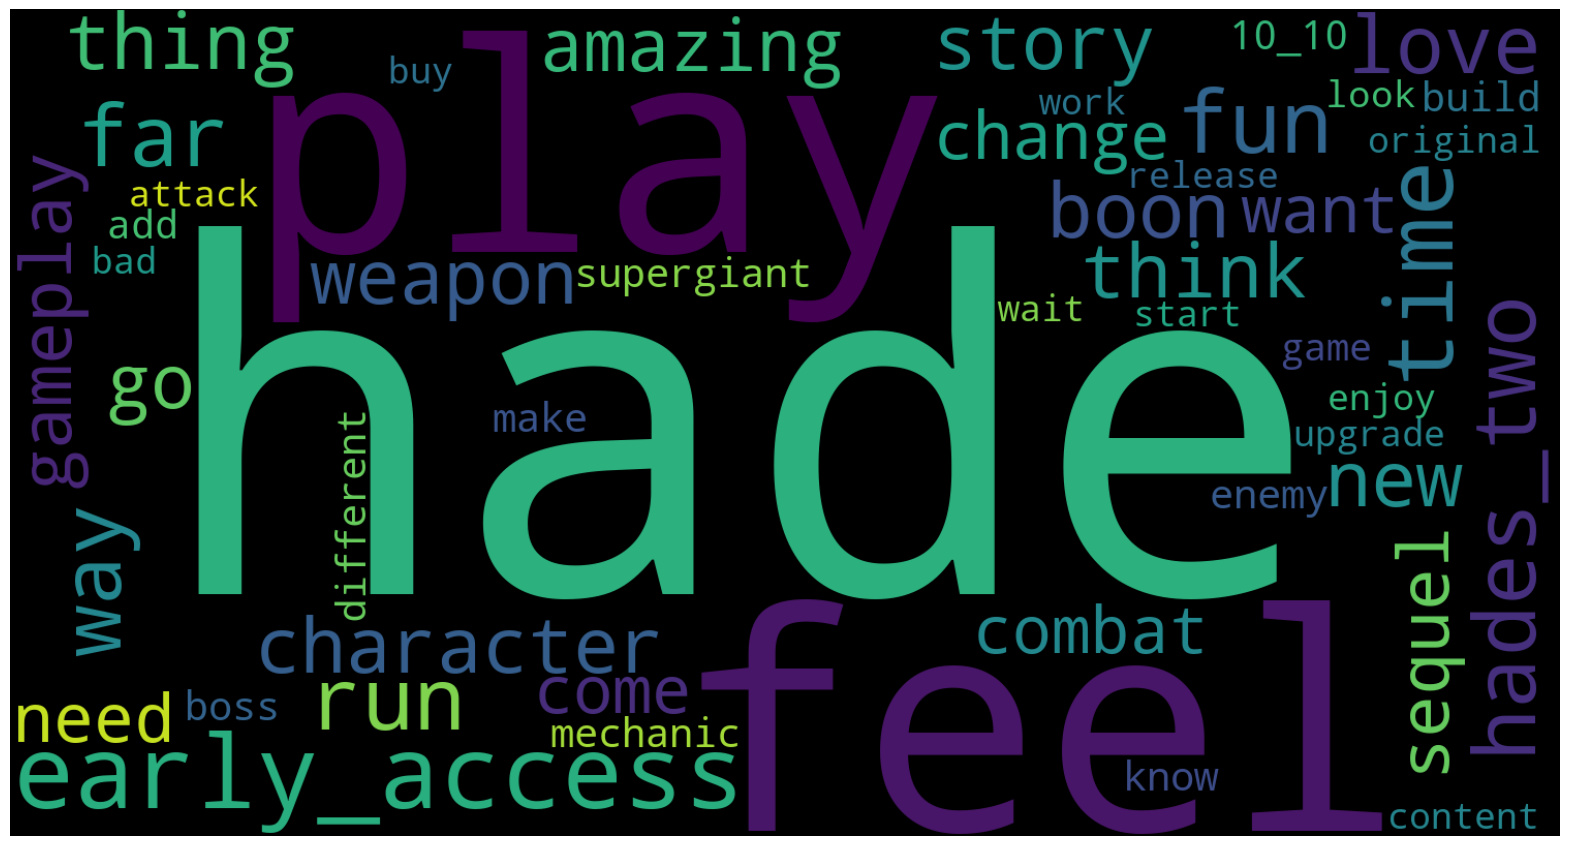

In [70]:
#generate wordcloud for 2grams
text_2grams = ' '.join(w for w in word_lst_2gram)

# Create and generate a word cloud image
wcd = wordcloud.WordCloud(width = 1500, height=800, max_words = 50).generate(text_2grams)

# Display the generated image:
plt.figure(figsize=(20,15))
plt.imshow(wcd, interpolation='bilinear')
plt.axis("off")
plt.show()

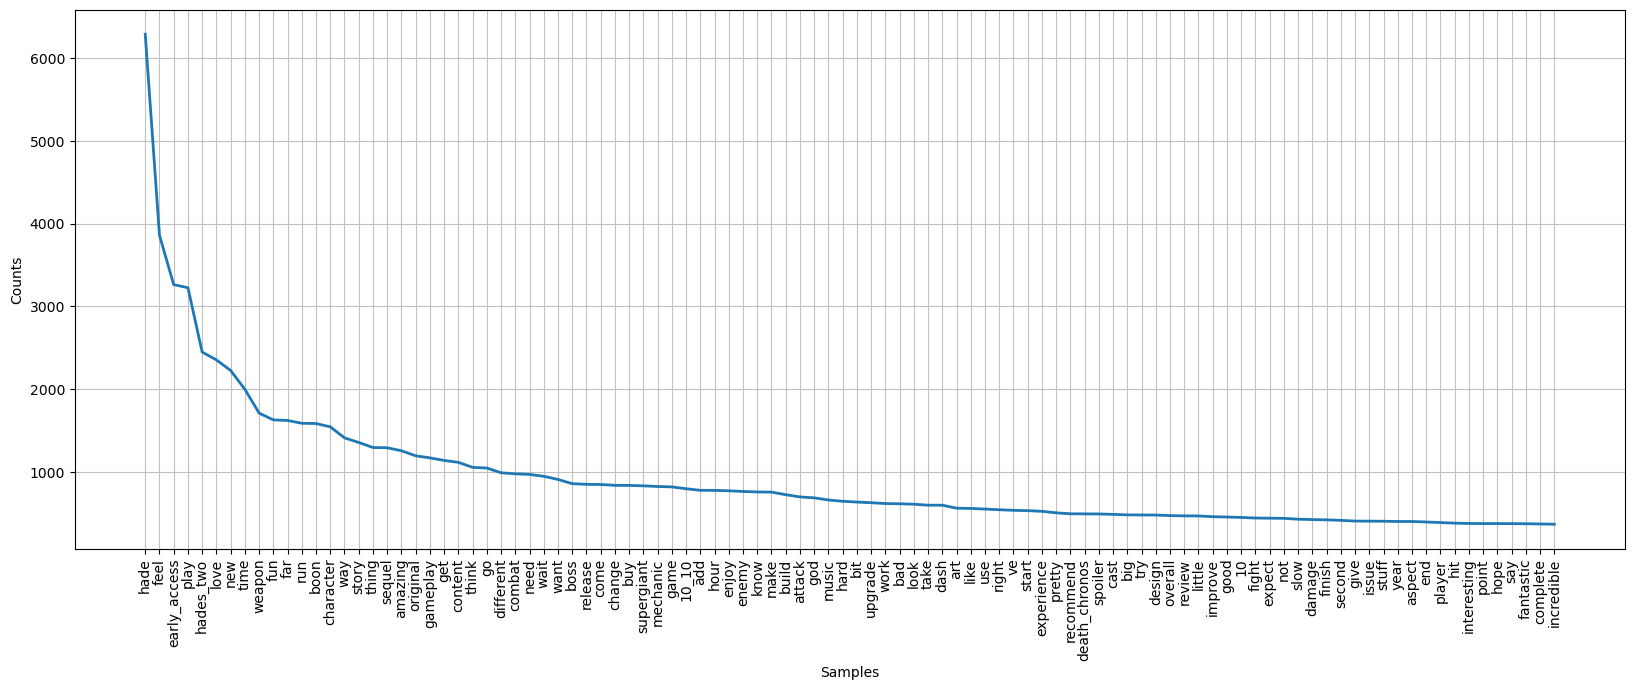

<Axes: xlabel='Samples', ylabel='Counts'>

In [71]:
wordfreq_2gram = nltk.FreqDist(word_lst_2gram)
# Print the most common words.
plt.figure(figsize=(20,7))
wordfreq_2gram.plot(100,cumulative=False)

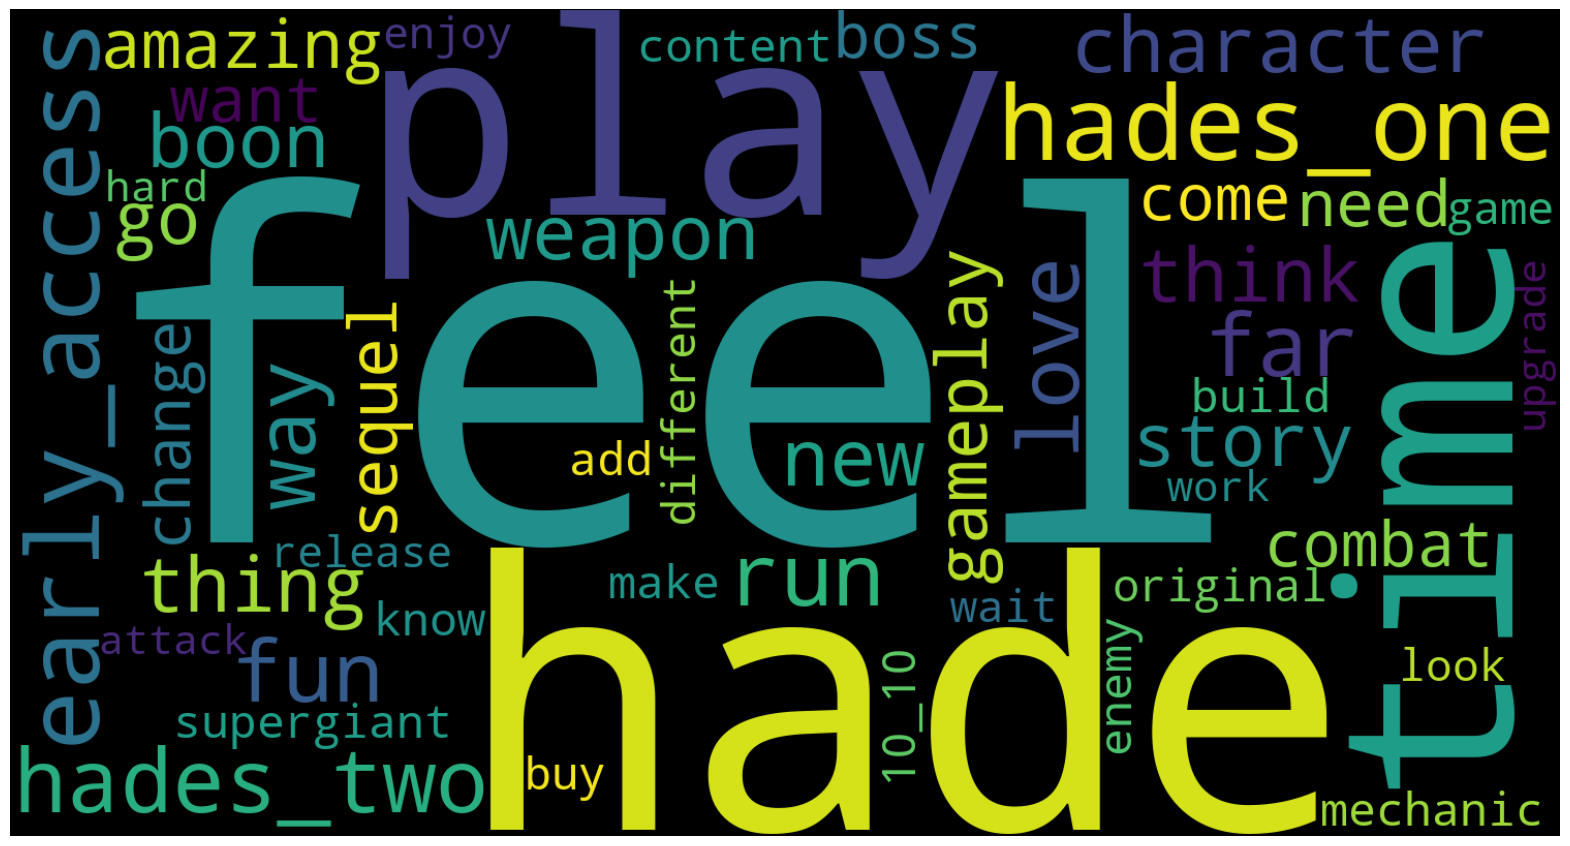

In [72]:
#generate wordcloud for 3grams
text_3grams = ' '.join(w for w in word_lst_3gram)

# Create and generate a word cloud image
wcd = wordcloud.WordCloud(width = 1500, height=800, max_words = 50).generate(text_3grams)

# Display the generated image:
plt.figure(figsize=(20,15))
plt.imshow(wcd, interpolation='bilinear')
plt.axis("off")
plt.show()

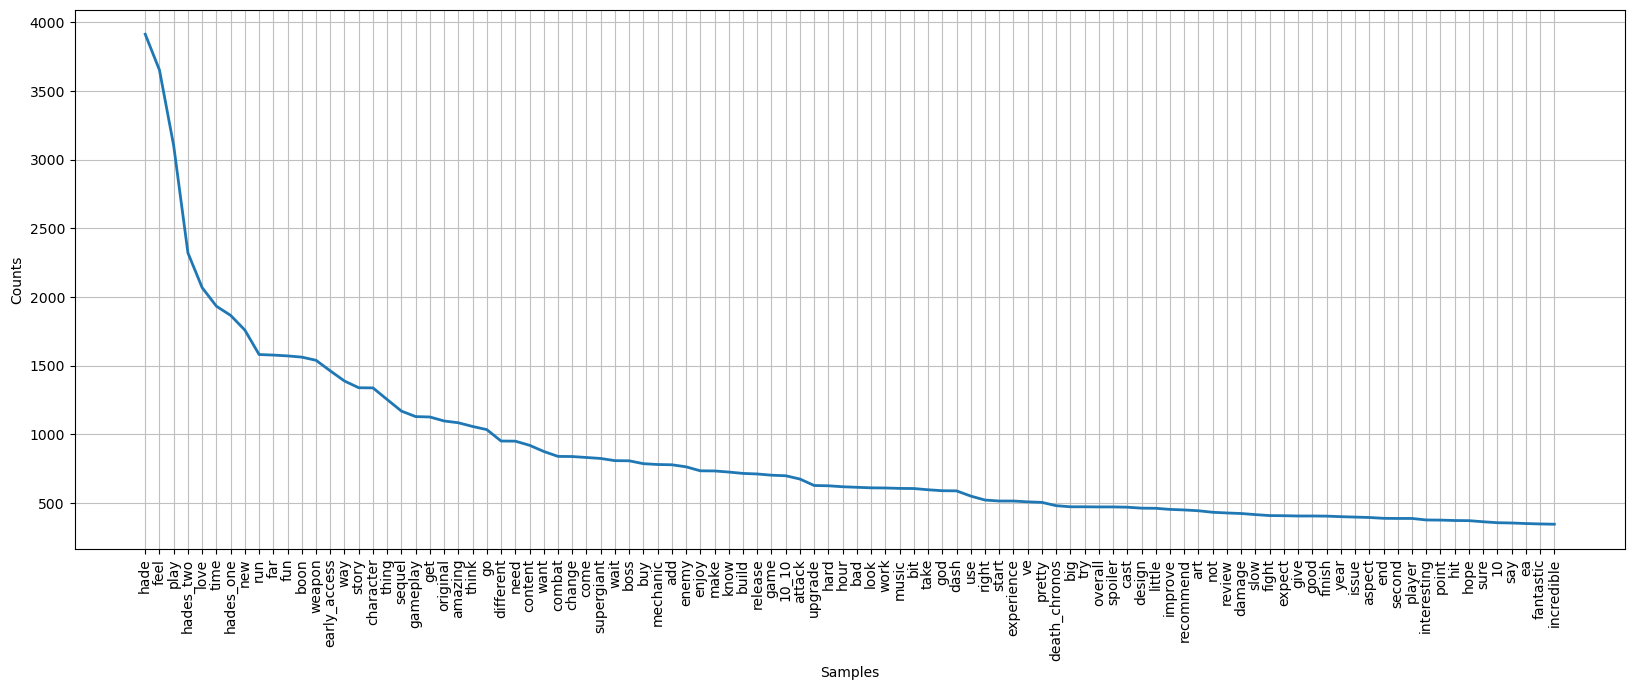

<Axes: xlabel='Samples', ylabel='Counts'>

In [73]:
wordfreq_3gram = nltk.FreqDist(word_lst_3gram)
# Print the most common words.
plt.figure(figsize=(20,7))
wordfreq_3gram.plot(100,cumulative=False)

In [75]:
#build dictionary and corpus from 3gram dataset -- NO filter_extremes

documents_3gram = list(final_df['3gram_reviews'])

dictionary_3gram = gensim.corpora.Dictionary(documents_3gram)

corpus_3gram = [dictionary_3gram.doc2bow(word) for word in documents_3gram]

In [76]:
#build dictionary and corpus from 2gram dataset -- NO filter_extremes

documents_2gram = list(final_df['2gram_reviews'])

dictionary_2gram = gensim.corpora.Dictionary(documents_2gram)

corpus_2gram = [dictionary_2gram.doc2bow(word) for word in documents_2gram]

In [77]:
#build dictionary and corpus from single dataset -- NO filter_extremes

documents_single = list(final_df['clean_reviews'])

dictionary_single = gensim.corpora.Dictionary(documents_single)

corpus_single = [dictionary_single.doc2bow(word) for word in documents_single]

In [78]:
# LDA model parameters. We will try 10 topics first
num_topics = 10
passes = 100
eval_every = None #Evaluation will happen later so no need to evaluate while training. Shortens training time.

In [79]:
#NOTE: This uses LDA Multicore. My system has 4 cores, so I used 3. Adjust "workers" value as needed for your system.

%time ldamodel1 = gensim.models.ldamulticore.LdaMulticore(corpus_3gram, num_topics=num_topics, id2word = dictionary_3gram, passes=passes, alpha='asymmetric',eval_every=eval_every,workers=3)

# Check resulting topics.
topic_list = ldamodel1.print_topics(num_topics=num_topics, num_words=15)
for index, i in enumerate(topic_list):
    str1 = str(i[1])
    for c in "0123456789+*\".":
        str1 = str1.replace(c, "")
    str1 = str1.replace("  ", " ")
    print(str1)

CPU times: total: 2min 15s
Wall time: 2min 19s
hade play love hades_two sequel amazing far new feel hades_one original time fun early_access story
feel boon weapon run time thing hades_one way boss play enemy fun think character new
early_access feel content hade combat hades_one play character new story release gameplay original enjoy far
buy go not do play I to m hour get fucking ve day love time
chrono s death_chronos die nemesis kill h yeah man that frog scylla _ siren oh
frog yes bath odysseus que mommy le cerberus way_kill en time la boss est finally
life save check hot_people_hot_people steam_deck fan play jogo  um need spoiler technical_test theme que
hades_two spoiler h h weapon attack slow movement dash boon hade issue button play feel
melinoe hecate brother zagreus god hope holy battle step enemy want city entire witch faith
hot pet aphrodite _ yes_yes_yesyes_yes st pet_cat fantastic gay love death_chronos  life artemis god


In [81]:
#NOTE: This uses LDA Multicore. My system has 4 cores, so I used 3. Adjust "workers" value as needed for your system.

%time ldamodel2 = gensim.models.ldamulticore.LdaMulticore(corpus_2gram, num_topics=num_topics, id2word = dictionary_2gram, passes=passes, alpha='asymmetric',eval_every=eval_every,workers=3)

# Check resulting topics.
topic_list = ldamodel2.print_topics(num_topics=num_topics, num_words=15)
for index, i in enumerate(topic_list):
    str2 = str(i[1])
    for c in "0123456789+*\".":
        str2 = str2.replace(c, "")
    str2 = str2.replace("  ", " ")
    print(str2)

CPU times: total: 2min 28s
Wall time: 2min 33s
hade love _ buy death_chronos play time sequel good want go pet_frog frog hot year
not do I m s feel weapon fun cool character bad h that boss get
early_access hade play hades_two love time content feel release far game hour wait come supergiant
feel boon weapon run hade enemy time thing way attack boss dash upgrade think new
hade new amazing feel gameplay far story character original fun sequel early_access combat love play
yes_yes die yesyes_yes kiss_frog _ spoiler st odysseus steam_deck chaos time ghost  second makes_feel
h h pastry crack wanna crash fix hot super_polished goty_ fill salt minute absolute_banger small
muscular_women fast day purchase buy happen friend  le que pause today controller est screen
hades_two death lord brother holy fan hope enemy city wait_final god master animal faith second
melinoe hecate hephaestus give zagreus encounter jogo man different increase journey way um time character


In [88]:
#NOTE: This uses LDA Multicore. My system has 4 cores, so I used 3. Adjust "workers" value as needed for your system.

%time ldamodel3 = gensim.models.ldamulticore.LdaMulticore(corpus_single, num_topics=num_topics, id2word = dictionary_single, passes=passes, alpha='asymmetric',eval_every=eval_every,workers=3)

# Check resulting topics.
topic_list = ldamodel3.print_topics(num_topics=num_topics, num_words=15)
for index, i in enumerate(topic_list):
    str3 = str(i[1])
    for c in "0123456789+*\".":
        str3 = str3.replace(c, "")
    str3 = str3.replace("  ", " ")
    print(str3)

CPU times: total: 1min 58s
Wall time: 2min 2s
hades one early two access new sequel love far play amazing story games original content
oh im goty yeah god year fucking love want scylla know aphrodite spoiler need gonna
one feel boons weapons feels run boss enemies time hades dash way weapon use fun
chronos death time supergiant buy games life best kill hours women purchase ve one played
frog pet hot banger kiss people bisexual deck bath steam cute gods wanted die got
drown pastry one gonna crown spider coral battle death crack holy lady lord god blood
  hecate odysseus come best shit abs one girl que le recommend artemis en
yes boss yesyes beat final second fight cause love mel baby nd fights got hecate
cat hotter melinoe dog instant woof bark check greek fear arf two charon small roguelike
nemesis peak mommy step strike cooked one dei greek makes fix reading let st gods


#### Compute Perplexity (want low) and coherence (higher the better)

In [85]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel1.log_perplexity(corpus_3gram))  # a measure of how good the model is. The lower the better.

# Compute Coherence Score
coherence_model_lda1 = CoherenceModel(model=ldamodel1, texts=documents_3gram, dictionary=dictionary_3gram, coherence='c_v')
coherence_lda1 = coherence_model_lda1.get_coherence()
print('\nCoherence Score: ', coherence_lda1)    #Not the be-all end-all. Still have to ensure that a human can read 


Perplexity:  -7.783620728151418

Coherence Score:  0.43605401161064317


In [86]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel2.log_perplexity(corpus_2gram))  # a measure of how good the model is. The lower the better.

# Compute Coherence Score
coherence_model_lda2 = CoherenceModel(model=ldamodel2, texts=documents_2gram, dictionary=dictionary_2gram, coherence='c_v')
coherence_lda2 = coherence_model_lda2.get_coherence()
print('\nCoherence Score: ', coherence_lda2)    #Not the be-all end-all. Still have to ensure that a human can read 


Perplexity:  -7.621682051558894

Coherence Score:  0.46189149147509545


In [87]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel3.log_perplexity(corpus_single))  # a measure of how good the model is. The lower the better.

# Compute Coherence Score
coherence_model_lda3 = CoherenceModel(model=ldamodel3, texts=documents_single, dictionary=dictionary_single, coherence='c_v')
coherence_lda3 = coherence_model_lda3.get_coherence()
print('\nCoherence Score: ', coherence_lda3)    #Not the be-all end-all. Still have to ensure that a human can read 


Perplexity:  -7.584416171312266

Coherence Score:  0.45104382239218255


#### Decided to go with the 2gram model (most coherent, 2nd lowest perplexity)

In [91]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaMulticore(corpus=corpus_2gram, id2word=dictionary_2gram, num_topics=num_topics, workers=3)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary_2gram, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

#### Graph coherence by number of topics

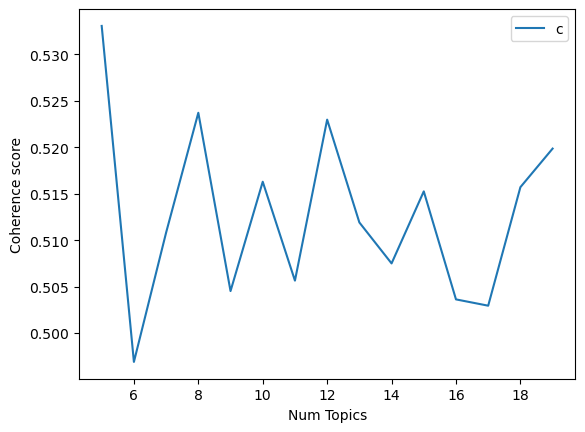

In [93]:
limit=20
start=5
step=1

model_list, coherence_values = compute_coherence_values(dictionary=dictionary_2gram, corpus=corpus_2gram, texts=list(final_df['2gram_reviews']), start=start, limit=limit, step=step)

# Show graph

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [95]:
#Using 8 topics because it has highest coherence
#build dictionary and corpus from 3gram dataset

documents_2gram = list(final_df['2gram_reviews'])
dictionary_2gram = gensim.corpora.Dictionary(documents_2gram)
corpus_2gram = [dictionary_2gram.doc2bow(word) for word in documents_2gram]

In [96]:
#LDA model parameters
num_topics = 8
passes = 100
eval_every = None #Evaluation will happen later so no need to evaluate while training

In [97]:
%time ldamodel2 = LdaMulticore(corpus_2gram, num_topics=num_topics, id2word = dictionary_2gram, passes=passes, alpha='asymmetric',eval_every=eval_every,workers=3)

# Check resulting topics.
topic_list = ldamodel2.print_topics(num_topics=num_topics, num_words=15)
for index, i in enumerate(topic_list):
    str2 = str(i[1])
    for c in "0123456789+*\".":
        str2 = str2.replace(c, "")
    str2 = str2.replace("  ", " ")
    print(str2)

CPU times: total: 2min 28s
Wall time: 2min 32s
hade love play hades_two time sequel buy supergiant early_access death_chronos want know like _ hour
early_access play content wait amazing release _ far fun go come game hade sequel feel
feel boon weapon run hade time enemy boss attack play thing way dash need think
chrono kill melinoe fight kiss_frog family odysseus girl hecate dora good titan death_chronos zagreus time
not do I m s yes_yes frog yesyes_yes muscular_women that be die there bad shit
hades_two h h fill fan pastry action minute darren_korb world gameplay time nice blend small
pet_cat frog_frog killing_time help ass witchy aphrodite vibe skill theme pro lose free_time omg witch
new hade feel character story gameplay play far original combat different love hades_two early_access fun


In [98]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel2.log_perplexity(corpus_2gram))

# Compute Coherence Score
coherence_model_lda2 = CoherenceModel(model=ldamodel2, texts=documents_2gram, dictionary=dictionary_2gram, coherence='c_v')
coherence_lda2 = coherence_model_lda2.get_coherence()
print('\nCoherence Score: ', coherence_lda2)


Perplexity:  -7.618345978828973

Coherence Score:  0.462840161941729


In [109]:
ldamodel2.save('model.lda')